https://h3imdallr.github.io/2017-08-19/arima/

1. Visualize the time series
2. Stationarize the series
3. Plot ACF/PACF charts and find optimal parameters
4. Build the ARIMA model
5. Make Predictions

In [38]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from dateutil.relativedelta import relativedelta

import statsmodels
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1. 시계열 데이터 확인하기

In [36]:
df = pd.read_csv('C:/dataset/kaggle_1_Everything you can do with a time series/portland-oregon-average-monthly.csv', index_col='Month')

In [20]:
df.head()

,ridership
Month,
1960-01-01,648
1960-02-01,646
1960-03-01,639
1960-04-01,654
1960-05-01,630


In [45]:
# preprocessing
df.dropna(axis=0, inplace=True)
df.columns = ['ridership']
print (df.head(),'\n ... \n', df.tail() )

ridership
Month             
1960-01        648
1960-02        646
1960-03        639
1960-04        654
1960-05        630 
 ... 
          ridership
Month             
1969-02       1425
1969-03       1419
1969-04       1432
1969-05       1394
1969-06       1327


In [46]:
# change df.index as datetime object
df.index = pd.to_datetime(df.index)
print(df.head(),'\n ... \n',df.tail())

ridership
Month                
1960-01-01        648
1960-02-01        646
1960-03-01        639
1960-04-01        654
1960-05-01        630 
 ... 
             ridership
Month                
1969-02-01       1425
1969-03-01       1419
1969-04-01       1432
1969-05-01       1394
1969-06-01       1327


In [29]:
# DF time slicing with datetime
time_window_l = datetime.datetime(1960, 3,1)
time_window_r = datetime.datetime(1961, 7,1)

temp_df = df[
    (df.index >= time_window_l)
    & (df.index <= time_window_r)]
# print (temp_df)

# temp_df = df[:time_window_l]
# print (temp_df)

In [30]:
temp_df

,ridership
Month,
1960-03-01,639
1960-04-01,654
1960-05-01,630
1960-06-01,622
1960-07-01,617
1960-08-01,613
1960-09-01,661
1960-10-01,695
1960-11-01,690


In [31]:
temp_df = df[:time_window_l]
print (temp_df)

ridership
Month                
1960-01-01        648
1960-02-01        646
1960-03-01        639


In [47]:
# change type of dataframe’s column
df['ridership'] = df['ridership'].astype(int)
print (df.dtypes)

ridership    int32
dtype: object


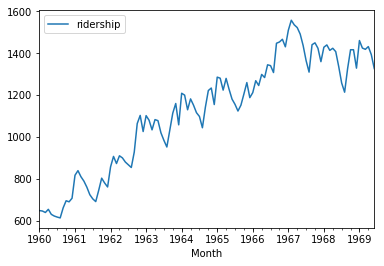

In [33]:
df.plot()

## Seasonal Decomposition (STL)

<Figure size 432x288 with 0 Axes>

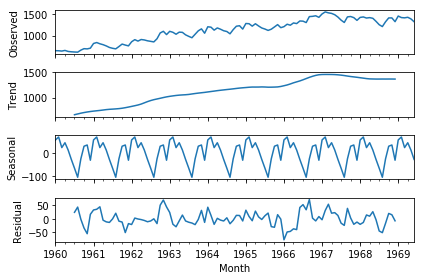

In [48]:
decomposition = seasonal_decompose(df['ridership'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()

# 2. 시계열 데이터 정상화 하기
## 정상성 확인 stationarity check
일반적으로 데이터가 stationary한 경우는 거의 없음. 정상성을 Test하기 위해서 두가지 방법 사용
- 눈으로 직관적 확인 ~ STL, Rolling statistics(moving average)
- Dickey-FUller test

In [58]:
# Dickey-Fuller test와 더불어 trend를 추출하는 방법중 하나인 rolling statistics를 이용해서 동시에 정상성을 검사하는 방법

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize=(10, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test:
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

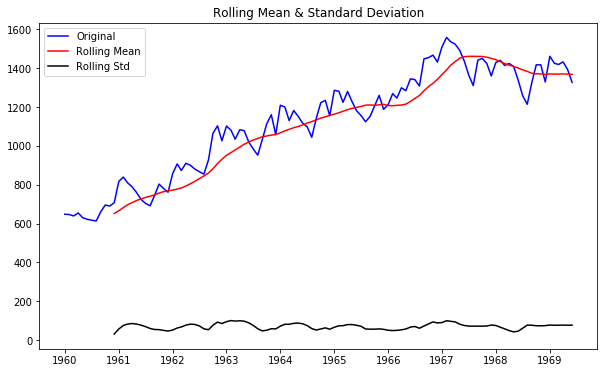

<Results of Dickey-Fuller Test>
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [59]:
test_stationarity(df['ridership'])

In [ ]:
'''
H0 : 시계열 자료가 비정상이다.
H1 : 시계열 자료가 정상이다.

p-value가 > 0.05 이므로 채택 -> ridership는 비정상 시계열 자료
'''

## 정상화 Stationarize
- 차분(differencing) : 1차차분. Trend 제거하는데 용이 $\Delta y_{t} = y_{t} - y_{t-1}$
- 로그변환(lograithm) : 표준편차가 자료의 크기에 비례하여 증가할때
- Box-Cox 변환 : 정규분포가 아닌 자료를 정규분포로 변환

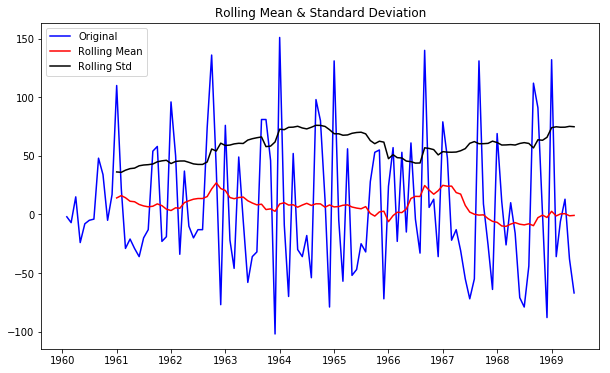

<Results of Dickey-Fuller Test>
Test Statistic                  -1.938696
p-value                          0.314082
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [60]:
# 차분을 이용하여 정상화

df['first_difference'] = df['ridership'] - df['ridership'].shift(1)  
# Or Alternatively,
# df.diff().plot()
test_stationarity(df.first_difference.dropna(inplace=False))

In [ ]:
'''
# Else:
# df['log_first_difference'] = df.riders_log - df.riders_log.shift(1)
# df['seasonal_difference'] = df.riders - df.riders.shift(12)  
# df['log_seasonal_difference'] = df.riders_log - df.riders_log.shift(12)
# df['log_seasonal_first_difference'] = df.log_first_difference - df.log_first_difference.shift(12)

'''

In [ ]:
# 좀더 나은 수준의 정상화를 위해, 또한 seasonal 패턴을 좀더 명확히 보고 싶고, long-term에서도 잘 남아있게 하기 위해서 seasonaly differencing 을 적용한다.

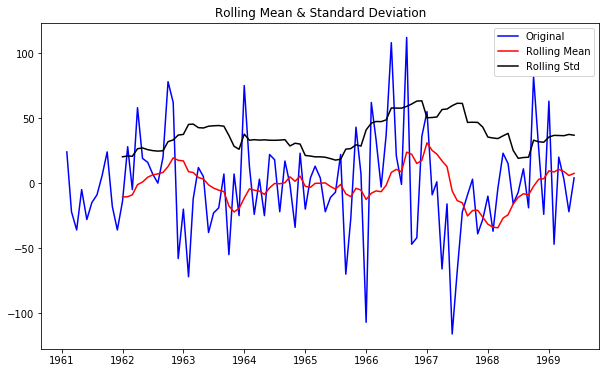

<Results of Dickey-Fuller Test>
Test Statistic                -9.258520e+00
p-value                        1.427874e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [61]:
df['seasonal_first_difference'] = df['first_difference'] - df['first_difference'].shift(12)  
test_stationarity(df.seasonal_first_difference.dropna(inplace=False))

In [ ]:
# p-value가 더 높아진 점에서 seasonal first difference를 통해 최종적으로 data를 정상화 시켰다고 판단
# 추가적으로 로그변환도 할 수 있으나, 본 경우에서는 분석후 크게 나아지지 않았음.
# 또한 추가로 추세를 추정하여 제거하는 기법들이 있으나, 충분히 정상화 되었다고 판단하고 본 분석에서는 소개하지 않는다.

## ARIMA 모델의 개념
### a. 정상과정 확률 모형(1/2) - General Linear Process Model
정상확률 과정에서 가장 일반적으로 사용되는 모형은 일반선형 확률 과정 모형(General Linear Process Model)

Yt = ϵt + ψ1ϵt−1 + ψ2ϵt−2 + ψ3ϵt−3 + ⋯

### b. 정상과정 확률 모형(2/2) - MA, AR, ARMA
일반 선형 확률 과정 모형은 계수의 특성에 따라 다음과 같은 하위 모형으로 분류된다.
- MA (Moving Average) 모형: 백색 잡음의 현재 값과 과거 값 중 유한(finite)개의 값에 대한 선형 가중합(linear weighted summation)으로 나타나는 확률 과정. q차수에 대해서 MA(q)로 표기
- AR (Auto-Regressive) 모형: 자기 자신의 과거값에 의존적인 모형. 백색 잡음의 현재값과 자기 자신의 과거값의 선형 가중합으로 이루어진 정상 확률 모형. p차수의 AR모형: AR(p)

이 모형이 선형확률과정을 따르는 것은 아래와 같이 증명 할 수 있다.
- ARMA (Auto-Regressive Moving Average) 모형: ARMA(p,q) 모형은 AR(p) 모형과 MA(q) 모형의 특징을 모두 가지는 모형을 말함.

### c. 비정상과정확률모형 - ARIMA

비정상 과정 모형 중 가장 대표적인 모형으로, ARMA 모형을 누적한 모형이다. 시계열 $Y_{t}$ 을 차분한 결과로 만들어진 시계열 $\nabla Y_t = Y_t - Y_{t-1}$ 이 ARMA 모형을 따르면 원래의 시계열 $Y_{t}$ 를 ARIMA(Autoregressive Integrated Moving Average) 모형이라고 한다.

만약 $d$ 번 차분한 후에야 시계열 $\nabla Y_t$ 가 ARMA(p,q) 모형을 따른다면 적분 차수(order of integration)가 $d$ 인 ARIMA 모형으로 ARIMA(p, d, q)로 표기한다. $q=0$ 인 경우에는 ARI(p,d), $p=0$ 인 경우에는 IMA(d,q)로 표기한다.

## ARIMA 모형 차수 결정
앞서 설명한 ARIMA의 p, d, q 모형차수는 아래와 같은 방법으로 결정 할 수 있다. 
- Augmented Dickey-Fuller 검정 : d
- 자기상관계수 함수(ACF): q
- 편자기상관계수 함수(PACF) : p

본 분석에서는 연단위(12개월) 차이로 정상화 시켜서, Seasonal ARIMA 모델로 분류됨.

Seasonal ARIMA 모형은 줄여서 SARIMA라고 하기도 한다. 단순 SARIMA 모형은 각 계절에 따른 독립적인 ARIMA 모형이 합쳐져 있는 모형이다. 기존 ARIMA(p,d,q) 모형에 계절성 주기를 나타내는 차수 s가 추가적으로 필요하기 때문에 SARIMA(P,D,Q,s) 로 표기한다.
s의 값은 월별 계절성을 나타낼 때는 $s=12$ 가 되고 분기별 계절성을 나타낼 때는 $s=4$ 가 된다.

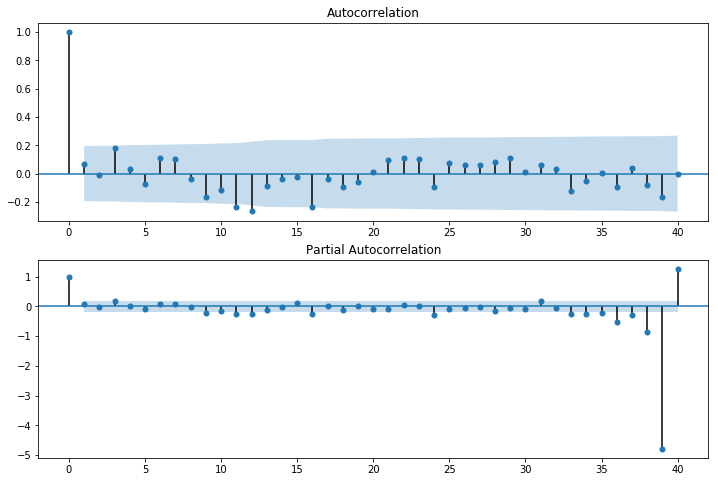

In [63]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.iloc[13:],lags=40,ax=ax2)

In [64]:
# 위 그래프에서, 1차 차분한 값이 t+1..t+12까지 AR(0), MA(0), d=1
# 12번째에서 +->- SAR(1), SMA(1)
# 최종적으로 SARIMA (0,1,0)X(1,1,1,12)

# 3. 모델 수립
위 단계에서 확정한 모델의 모형차수를 이용하여, (Seasonal) ARIMA 모델을 생성한다

In [65]:
mod = sm.tsa.SARIMAX(df['ridership'], order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
print (results.summary())

C:\Users\jieun\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
                                 Statespace Model Results                                 
Dep. Variable:                          ridership   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -501.340
Date:                            Sun, 10 May 2020   AIC                           1008.680
Time:                                    03:48:17   BIC                           1016.526
Sample:                                01-01-1960   HQIC                          1011.856
                                     - 06-01-1969                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.

## 평가
모형이 훌륭하다면 이 값은 더이상 예측할 수 있는 요소가 전혀 없는 시계열 즉, 가우시안 백색 잡음에 가까운 특성을 보여야 한다.

백색잡음: 백색 잡음 $e$ 은 확률 과정을 구성하는 모든 개별 확률 변수 $e_{t}$ 들이 서로 독립이고(independent) 동일한 확률 분포를 따르는(identically distributed) 확률 과정을 말한다.

백색 잡음은 다음과 같은 특성을 만족한다.
- 정상 과정(stictly stationary process)이다.
- 시차(lag)가 0일 경우, 자기공분산은 확률 분포의 분산이 되고 시차가 0이 아닌 경우, 자기공분산은 0이다.
- 시차(lag)가 0일 경우, 자기상관계수는 1이 되고 시차가 0이 아닌 경우, 자기상관계수는 0이다.

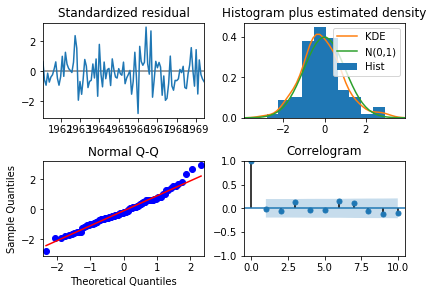

In [66]:
# 잔차의 정규성과 자기상관계수 함수
results.plot_diagnostics()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# 4. 시계열 예측

,ridership,first_difference,seasonal_first_difference,forecast
Month,,,,
1968-07-01,1258,-79.0,-7.0,1296.345024
1968-08-01,1214,-44.0,11.0,1258.594994
1968-09-01,1326,112.0,-19.0,1356.835554
1968-10-01,1417,91.0,82.0,1395.806826
1968-11-01,1417,0.0,26.0,1394.654250
1968-12-01,1329,-88.0,-24.0,1339.625090
1969-01-01,1461,132.0,63.0,1424.047864
1969-02-01,1425,-36.0,-47.0,1438.088914
1969-03-01,1419,-6.0,20.0,1407.274407


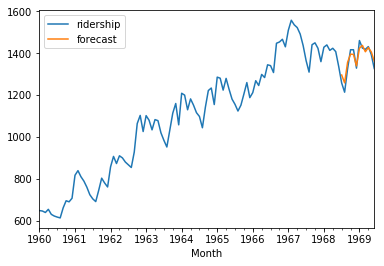

In [68]:
df['forecast'] = results.predict(start = len(df)-12, end= len(df), dynamic= True)  
df[['ridership', 'forecast']].plot()
df[-12:]

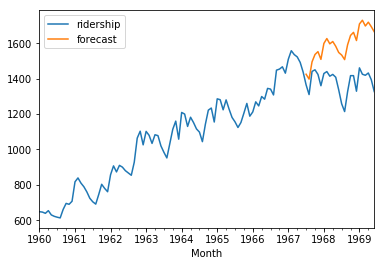

In [69]:
# 예측 기간이 길어질수록 부정확해 질 수 있음 (24개월)
df['forecast'] = results.predict(start = len(df)-24, end= len(df), dynamic= True)  
df[['ridership', 'forecast']].plot()